# 5. Training in Physics

In the last notebook events from the Di-Higgs signal process and some of its background processes were selected which fulfilled a desired signiture consisting of lepton and jet counts and requirements on some physical observables. The selected data was then converted into a vector form which can be used as input by a neural network and saved into files.

In this notebook a neural network will be constructed which is capable of taking the selected data from the last notebook as input and target values for the training will be constructed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep
import os

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import RandomUniform

2022-08-23 16:44:26.924685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-23 16:44:26.924740: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# open the neural network input vectors

nn_input = {}

# 'bgr_Wj'
processes = ['signal', 'bgr_tt', 'bgr_st']

for process in processes:
    nn_input[process] = np.loadtxt('nn_input_' + process + '.txt', delimiter = ' ')
    
    # simplify data structure by transposing
    nn_input[process] = np.transpose(nn_input[process]).tolist()

Not only do we want to understand if the if the event in question is part of the signal or the background, we also want to be able to differentiate the various background processes. Essentially, we are building a *multiclassifier* neural network. This means that the network, instead of returning a binary "signal" or "background" response, returns an output vector of which each element is associated with the probablility of identifying the events as stemming from the various processes. In our case we have 4 processes that have to be distinguished from one another; an exemplary output vector of the shape (0 0 1 0) would indicate the ideal case of identifying an event as a single top background event.

In [3]:
# define structure of the network

# dimensions of input, hidden and output layers
N0 = len(nn_input['signal'][0])
N1 = 256
N2 = len(processes)

# number of hidden layers
layer_count = 3

# layer structure of the network
layers = [N0]

for l in range(layer_count):
    layers.append(N1)
    
layers.append(N2)

print("Layer structure of the network: ", layers)

Layer structure of the network:  [15, 256, 256, 256, 3]


In [4]:
# construct the network in keras

net = Sequential()

# set the weights initializer
initializer = RandomUniform(minval=-1, maxval=1)

# make the first layer with the input shape as an argument
net.add(Dense(layers[1], input_shape = (layers[0],), activation = 'sigmoid', 
              use_bias = True, kernel_initializer = initializer))

# make all the other layers
for i in range(2, len(layers) - 1):
    net.add(Dense(layers[i], activation = 'sigmoid', use_bias = True, kernel_initializer = initializer))
    
net.add(Dense(layers[-1], activation = 'softmax', use_bias = True, kernel_initializer = initializer))

2022-08-23 16:44:30.379206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-23 16:44:30.379242: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-23 16:44:30.379274: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (batch1359.desy.de): /proc/driver/nvidia/version does not exist
2022-08-23 16:44:30.379508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# compile the network

# net.compile(loss = 'CategoricalCrossentropy', optimizer = keras.optimizers.SGD(learning_rate = 0.5), metrics = ['accuracy'])
net.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.SGD(learning_rate = 0.025), metrics = ['categorical_accuracy'])

In [6]:
# making of the target output

# target dictionary
nn_target = {}

training_duration = 0

# make target data for a particular process
def make_target(p, proc):
    
    vectors = []
    
    for i in range(len(nn_input[proc])):
    
        v = np.zeros(len(processes))
        v[p] = 1

        vectors.append(v)
    
    return vectors, len(vectors)

In [7]:
# make target data for all processes
for count, process in enumerate(processes):
    nn_target[process] = make_target(count, process)[0]
    training_duration += make_target(count, process)[1]

print(nn_target['signal'][10])

[1. 0. 0.]


In [8]:
# number of batches
batches = 2000

# cost
costs = np.empty(batches)
metrics_1 = np.empty(batches)
metrics_2 = np.empty(batches)
metrics_3 = np.empty(batches)

print(type(nn_input['signal']))
print(type(nn_target['signal']))

<class 'list'>
<class 'list'>


In [9]:
# put input and target data all in one array

nn_input_training = []
nn_target_training = []

for process in processes:
    nn_input_training = nn_input_training + nn_input[process][:3000]
    nn_target_training = nn_target_training + nn_target[process][:3000]

nn_input_training = np.array(nn_input_training)
nn_target_training = np.array(nn_target_training)
    
print(np.shape(nn_input_training))
print(np.shape(nn_target_training))

(9000, 15)
(9000, 3)


In [10]:
# permutate for training

p = np.random.permutation(len(nn_input_training))

nn_input_training = nn_input_training[p]
nn_target_training = nn_target_training[p]

In [11]:
# train network

for i in range(batches):
    costs[i] = net.train_on_batch(nn_input_training, nn_target_training)[0]
    metrics_1[i] = net.train_on_batch(nn_input_training, nn_target_training)[1]

Lowest cost value:  0.9041823744773865


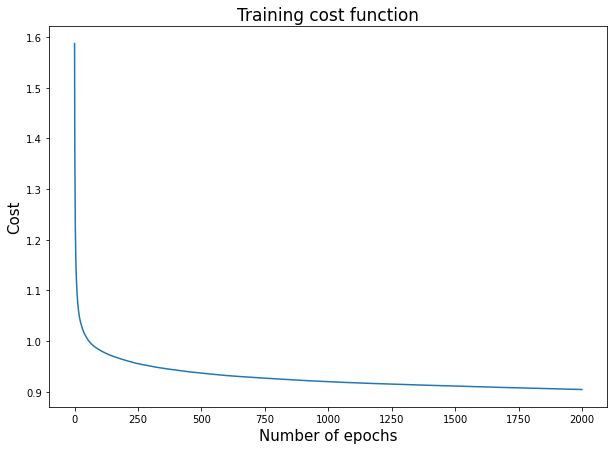

In [12]:
plt.figure(figsize = (10, 7), facecolor = 'white')

plt.plot(costs)

plt.title('Training cost function', fontsize = 17)
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Cost', fontsize = 15)

print('Lowest cost value: ', costs[-1])

Highest accuracy value:  0.5554444193840027


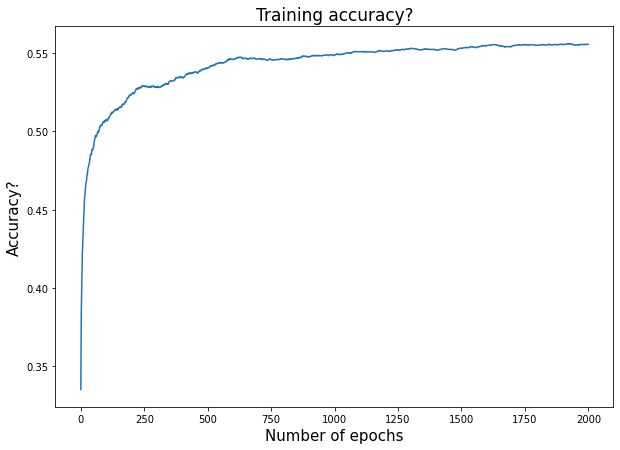

In [13]:
plt.figure(figsize = (10, 7), facecolor = 'white')

plt.plot(metrics_1)

plt.title('Training accuracy?', fontsize = 17)
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Accuracy?', fontsize = 15)

print('Highest accuracy value: ', metrics_1[-1])

In [14]:
predictions = {}

for process in processes:
    predictions[process] = net.predict_on_batch(np.array(nn_input[process][3000:4344]))
    
    mean_classifier = []
    
    for i in range(3):
        mean_classifier.append(np.mean(predictions[process][:, i]))
        
    print('Mean classifier of ' + process + ' process', mean_classifier)
        

# probe = net.predict_on_batch(np.array([nn_input['signal'][100]]))

Mean classifier of signal process [0.47745377, 0.25314045, 0.26940572]
Mean classifier of bgr_tt process [0.24250844, 0.3909517, 0.3665399]
Mean classifier of bgr_st process [0.2597078, 0.36187038, 0.37842178]
